In [14]:
import os
import sys 

%load_ext autoreload
import torch
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet
from sklearn.impute import SimpleImputer, KNNImputer
from torch.nn.functional import interpolate
from awloss import AWLoss

from train_utils import *

%autoreload 2
sys.path.append('../')
from networks import *
from datasets import MaskedUltrasoundDataset2D
from landscape import *


import matplotlib.pyplot as plt
import matplotlib.colors as clt
import progressbar
import random
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CUDA Setup

In [15]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)            

Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [16]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
size = 256
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(size),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [0., 1.])),
                    ])

mask = create_mask((size,size), (0,3), (0,1))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=None)
print(ds, "\n")
print(ds.info(nsamples=30))


{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': None, 'transform': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'mode': 'mri', 'len': 553} 

{'max': 1.0, 'min': 0.0, 'mean': 0.04609345644712448, 'std': 0.11560549587011337, 'shape': torch.Size([1, 256, 256])}


## Data split

In [17]:
valid_ratio = 0.2
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

443 110


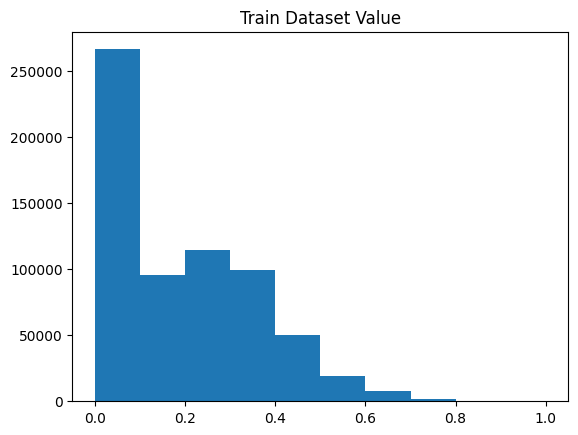

In [18]:
data = []
for i in range(min(len(trainds), 10)):
    data += list((trainds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

# Model 

In [19]:
def make_model(nc=64):
    set_seed(42)
    channels = (16, 32, 64)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=3,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)

# Train Function

In [20]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, 
                log_frequency=10, sample_input=None, sample_target=None, device="cpu", 
                exp_name="", save=True, scheduler=None):
                
    print("\n\nTraining started ...")
    try:
        all_train_losses, all_valid_losses = [], []
        with progressbar.ProgressBar(max_value=nepochs) as bar:    
            for epoch in range(nepochs):
                # Train and validate epoch
                train_loss = train(model, train_loader, optimizer, loss, scheduler, device)
                all_train_losses.append(train_loss.item())
                if valid_loader:
                    valid_loss = validate(model, valid_loader, loss, device)
                    all_valid_losses.append(valid_loss.item())
                
                bar.update(epoch)
                
                # Logging
                log = {"epoch": epoch, "train_loss": train_loss.item()}
                if valid_loader:
                    log.update({"valid_loss": valid_loss.item()})
                    
                if (epoch % log_frequency == 0 or epoch==nepochs-1):
                    print("\n", log)

                    if valid_loader:
                        model.eval()
                        X, target = next(iter(valid_loader))
                        X, target = X[:train_loader.batch_size], target[:train_loader.batch_size]
                        recon = torch.sigmoid(model(X))

                        fig, axs = plt.subplots(4, 1, figsize=(10*train_loader.batch_size, 15))
                        axs[0].imshow(make_grid(X, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        axs[1].imshow(make_grid(recon, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        axs[2].imshow(make_grid(target, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data[0], cmap='Greys_r')
                        try:
                            loss(X, target)
                            v = loss.filters
                        except:
                            v = torch.zeros_like(X)
                        axs[3].imshow(make_grid(v, pad_value=0, padding=2, vmin=-0.1, vmax=0.1).cpu().data[0], cmap='seismic')
                        plt.show()

                    if sample_input is not None:
                        idx = int(sample_input.shape[0]/2)
                        samples = {"Input idx %g"%idx: sample_input[idx]}

                        # Model forward pass
                        model.eval()
                        X = sample_input.unsqueeze(0).to(device)
                        recon = torch.sigmoid(model(X))[0]
                        samples.update({"Reconstruction idx %g"%idx: recon[idx].cpu().detach().numpy()})

                        # If testing sample provided
                        if sample_target is not None:
                            samples.update({"Target idx %g"%idx: sample_target[idx]})

                            # Loss evaluation and filters
                            f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                try:
                                    loss_list = [str(l) for l in loss.losses]
                                    awloss = loss.losses[loss_list.index("AWLoss()")]
                                    v, T = awloss.filters[0], awloss.T
                                except:
                                    v, T = torch.tensor([0.]), torch.tensor([0.])
                            print(" argidx T, v: ",torch.argmin(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                
                    samples_fig = plot_samples(samples)
                    losses_fig = plot_losses(losses={"train": all_train_losses, "valid":all_valid_losses},
                                filters={"Weiner Filter": v.flatten().cpu().detach().numpy(), "Penalty": T.flatten().cpu().detach().numpy()})
        raise(KeyboardInterrupt)
    except KeyboardInterrupt:                                   
        if save:
            objs = { "mask": train_loader.dataset.dataset.mask,
                "train_loader":train_loader,
                "valid_loader":valid_loader,
                "x_sample": x_sample,
                "y_sample": y_sample,
                "recon": recon,

                "model": model,
                "optim": optimizer,
                "loss": loss,
                "train_losses": all_train_losses,
                "vald_losses": all_valid_losses,
                "penalty": T,
                }

            summary = { "data_mode": train_loader.dataset.dataset.mode,
                        "interpolation_model": "UNet",
                        "loss": str(loss),
                        "img_size": x_sample.numpy().shape,
                        "device":device,
                        "nepochs": nepochs,
                        "current_epoch":epoch, 
                        "learning_rate":optimizer.defaults["lr"],
                        "batch_size":train_loader.batch_size,
                        "ntrain": len(train_loader.dataset),}
            try:
                summary["nvalid"]= len(valid_loader.dataset)
            except:
                summary["nvalid"]= 0
            try:
                summary["aw_filter_dim"] = loss.filter_dim,
                summary["aw_epsilon"] =  loss.epsilon,
                summary[ "aw_std"] = loss.std
            except:
                summary["aw_filter_dim"] = None
                summary["aw_epsilon"] =  None
                summary[ "aw_std"] = None

            figs = {"losses":losses_fig, "samples":samples_fig}
            save_exp(objs=objs, figs=figs, summary=summary, overwrite=False)            
    return None
            

# Training Setup

In [21]:
# Set training static parameters and hyperparameters
nepochs=300                        
learning_rate=1e-2
batch_size=32                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]
f = (nepochs//2) + 1

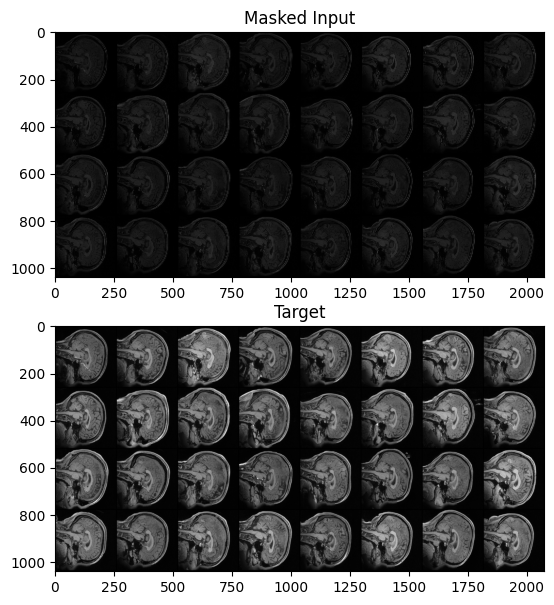

In [22]:
train_batch = next(iter(train_loader))
fig, axs = plt.subplots(2, 1, figsize=(4*batch_size,7))
axs[0].imshow(make_grid(train_batch[0], pad_value=0, padding=3).data[0], cmap='Greys_r')
axs[0].set_title("Masked Input")
axs[1].imshow(make_grid(train_batch[1], pad_value=0, padding=3).data[0], cmap='Greys_r')
axs[1].set_title("Target")
plt.show()

# Train AWLoss

In [23]:
def laplacian2D(mesh):
    alpha, beta = -0.2, 1.5
    xx, yy = mesh[:,:,0], mesh[:,:,1]
    x = torch.sqrt(xx**2 + yy**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.05, 1.])
    return T

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")




Training started ...


[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.4136790633201599, 'valid_loss': 0.24272078275680542}


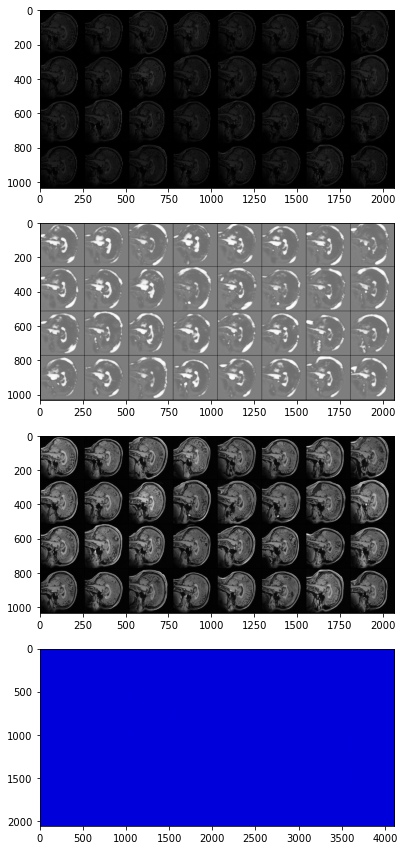

 argidx T, v:  0 130560


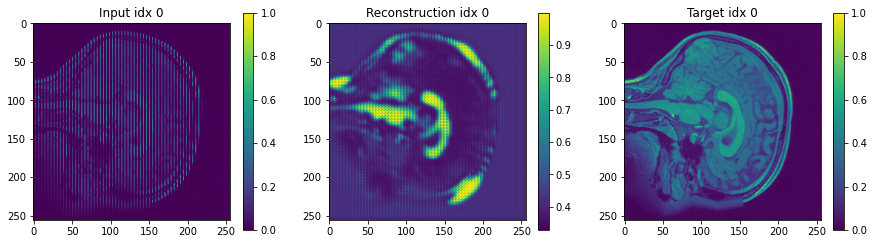

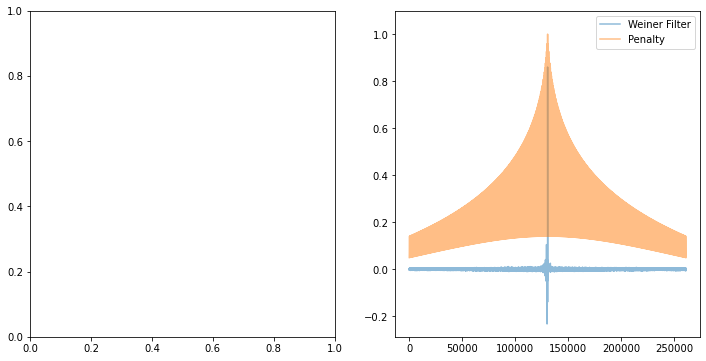

 33% (100 of 300) |#######               | Elapsed Time: 0:08:34 ETA:   0:17:34


 {'epoch': 100, 'train_loss': 0.0785524770617485, 'valid_loss': 0.07855982333421707}


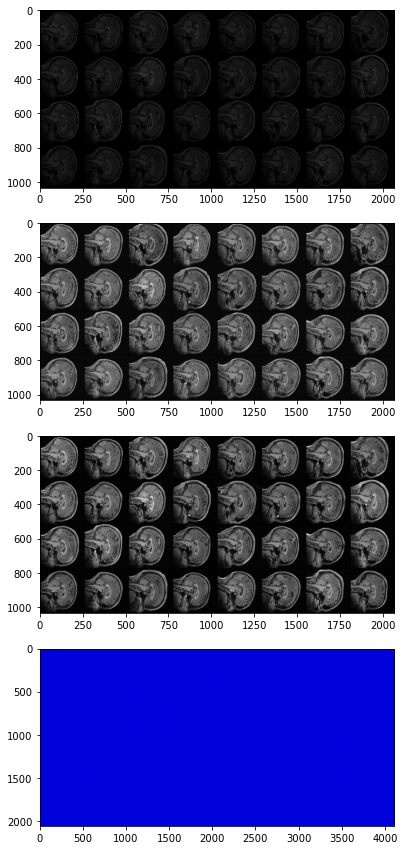

 argidx T, v:  0 130560


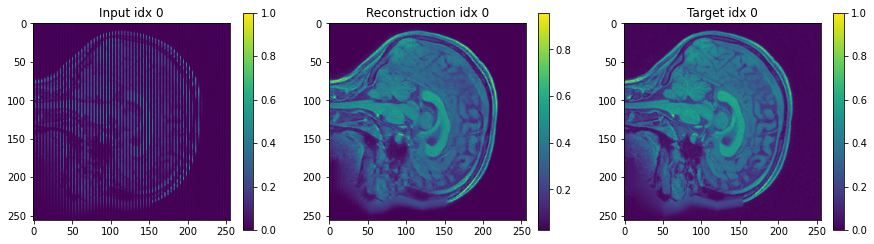

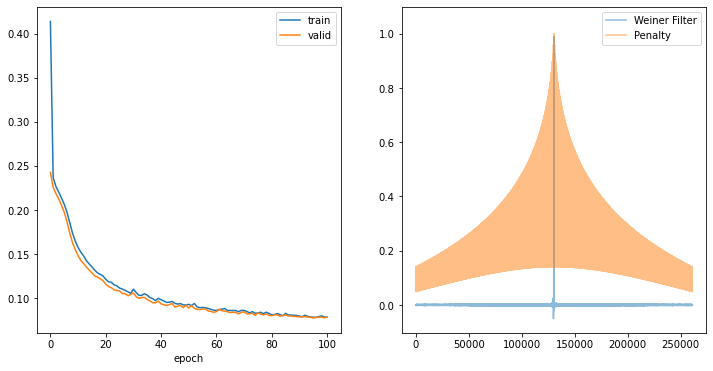

 66% (200 of 300) |##############        | Elapsed Time: 0:17:11 ETA:   0:08:17


 {'epoch': 200, 'train_loss': 0.06864257901906967, 'valid_loss': 0.07288546860218048}


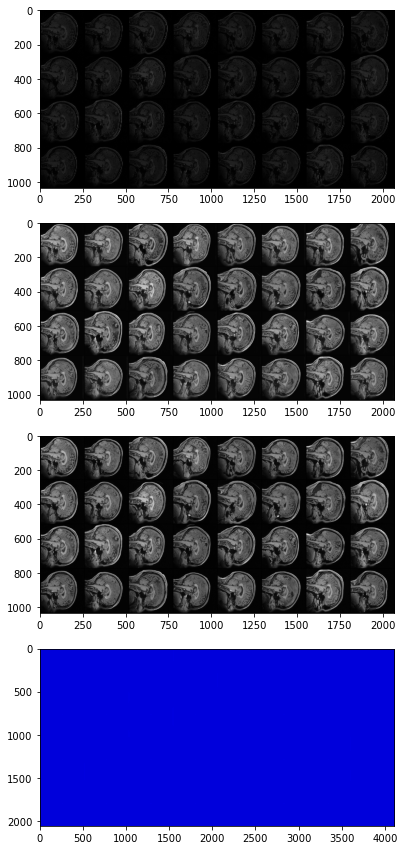

 argidx T, v:  0 130560


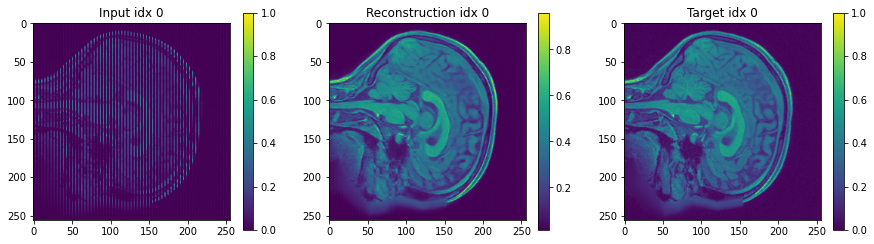

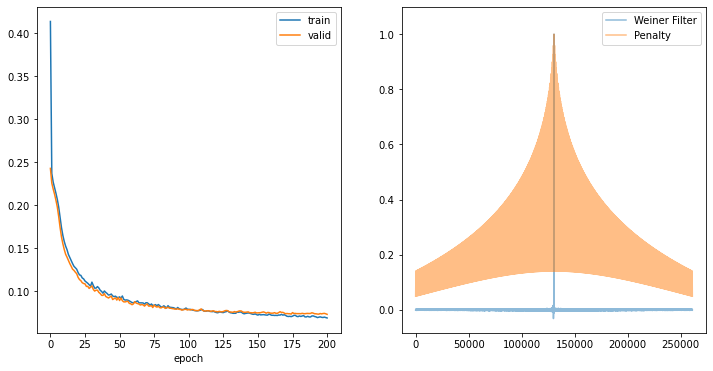

 99% (299 of 300) |##################### | Elapsed Time: 0:25:46 ETA:   0:00:05


 {'epoch': 299, 'train_loss': 0.06423334032297134, 'valid_loss': 0.07216491550207138}


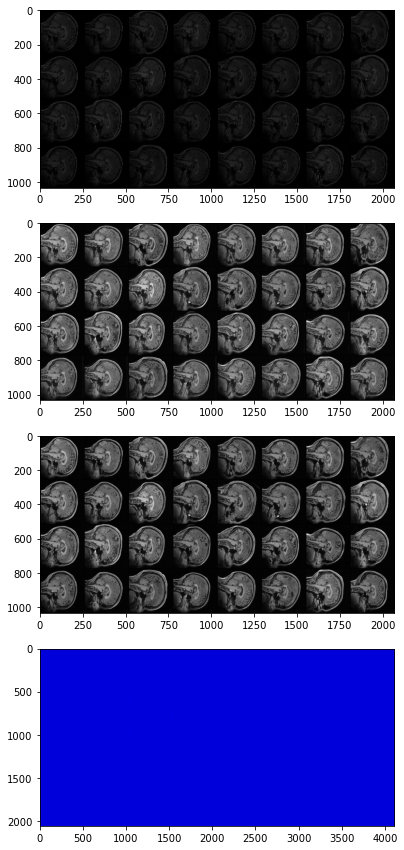

 argidx T, v:  0 130560


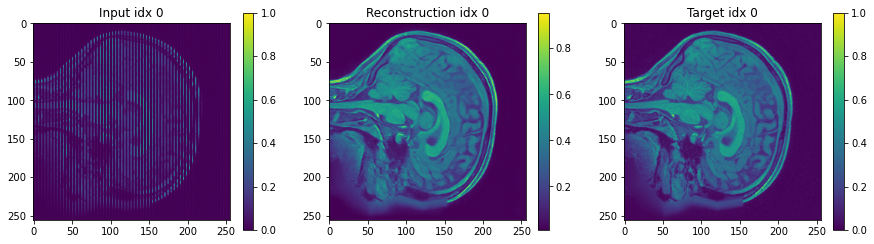

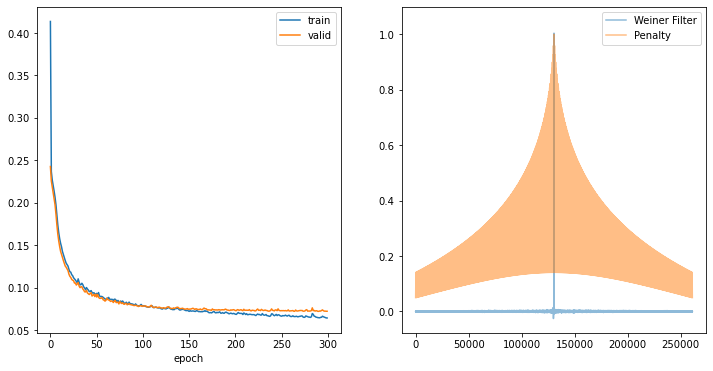

100% (300 of 300) |######################| Elapsed Time: 0:25:51 Time:  0:25:51


Saving experiment at /home/dp4018/scripts/lsrcodes/exp91 ...
	 exp91/mask.pkl
	 exp91/train_loader.pkl
	 exp91/valid_loader.pkl
	 exp91/x_sample.pkl
	 exp91/y_sample.pkl
	 exp91/recon.pkl
	 exp91/model.pkl
	 exp91/optim.pkl
	 exp91/loss.pkl
	 exp91/train_losses.pkl
	 exp91/vald_losses.pkl
	 exp91/penalty.pkl
	 exp91/losses.png
	 exp91/samples.png
	 summary.json


In [11]:
awmodel = make_model(nc=x_sample.shape[0])
awoptim = torch.optim.Adam(awmodel.parameters(), lr=learning_rate)

awloss     = AWLoss(filter_dim=2, method="fft", reduction="mean", store_filters="unorm", 
                    epsilon=250., filter_scale=2, penalty_function=laplacian2D)


train_model(awmodel, awoptim, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=100, 
            sample_input=x_sample, sample_target=y_sample, device=device, save=True)


